### Burger's equation
For a given field $u(x,t)$ and diffusion coefficient (or kinematic viscosity, as in the original fluid mechanical context) $\nu$ , the general form of Burgers' equation (also known as viscous Burgers' equation) in one space dimension is the dissipative system:
$$u_t + uu_x = \nu u_{xx} $$
Consider initial value problem:
$$u(x,0) = u_0(x) $$
for periodic boundary conditions on an interval of length $L$:
$$ u(x+L, t) = u(x,t)$$
Introduce grid values $u_k(t) = u(\frac{kL}{N},t)$ for $k = 0, \dots , N-1$.

Let $\Delta x = \frac{L}{N}$, $\Delta t = \frac{T}{M}$, $u_k^j = u( k \Delta x, n \Delta t)$

Discretize $ u_{xx}$,$u u_x $, $u_t$ by
$$ u_{xx} = (\frac{N}{L})^2 (u_{k+1} + u_{k-1} - 2 u_k) = \frac{u_{k+1} + u_{k-1} - 2 u_k}{(\Delta x)^2}$$
$$ u u_x = (\frac{N}{2 L}) u_k (u_{k+1} - u_{k-1}) = \frac{u_k (u_{k+1} - u_{k-1})}{2 \Delta x}$$
$$ u_t = \frac{u_k^{n+1} - u_k^n}{\Delta t}$$
The equation is approximated by 
$$ \frac{u_k^{n+1} - u_k^n}{\Delta t} + \frac{u_k^n (u_{k+1}^n - u_{k-1}^n)}{2 \Delta x} = \nu \frac{u_{k+1}^n + u_{k-1}^n - 2 u_k^n}{(\Delta x)^2} $$
$$ u_k^{n+1} = u_k^n  -\frac{\Delta t}{2 \Delta x} (u_k^n (u_{k+1}^n - u_{k-1}^n)) + \frac{\nu \Delta t}{(\Delta x)^2}(u_{k+1}^n + u_{k-1}^n - 2 u_k^n) $$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import sys; sys.path.append('../')
from PDE_FIND import *
import scipy.io as sio
import itertools
from IPython.display import display, HTML, display_html, Latex
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
def Burger(N, nu, T, M, L, initial):
    dx = L / N
    dt = T / M
    x = np.linspace(-L, L, N+1)  # Spatial grid points
    u_initial = initial(x)
    u = np.zeros((N+1, M+1),dtype=np.double)
    u[:,0] = u_initial
    t = 0
    dx2 = dx**2
    for n in range(1,M+1):
        for j in range(1,N):
            ux = 0.5*(u[j+1,n -1] - u[j-1,n-1]) / dx
            diffusion = nu * (u[j+1, n-1] - 2*u[j, n-1] + u[j-1, n-1]) / dx**2
            u[j,n] = u[j,n-1]-dt*u[j,n-1]*ux + dt*diffusion
            # print(u[j,n])
        ux = 0.5*(u[0,n-1] - u[N-1,n-1]) / dx
        diffusion = nu * (u[0, n-1] - 2*u[N, n-1] + u[N-1, n-1]) / dx**2
        u[N,n] = u[N,n-1]-dt*u[j,n-1]*ux + dt*diffusion
        u[0, n] = u[N, n]
    return u

These expressions are accurate to $O((\Delta x)^2)$ with $\Delta x = L/N$. We may nondimensionalize these equations by setting 
$$v_k(s) = (\frac{L}{N \nu}) u_k(\frac{L^2 s}{N^2 \nu}), \quad k = 0, \dots , N-1 $$

### Crank-Nicholson scheme

Approximate $u_t$ by forward scheme, $u u_x$ by central difference at $t = t_n$ and $t = t_{n+1}$, and $k u_{xx}$ is approximated by Crank-Nicholson expression.
$$u_t \approx \frac{u_j^{n+1} - u_j^n}{\Delta t}$$
$$u u_x \approx \frac{1}{2}(u_{j}^n \frac{u_{j+1}^{n+1} - u_{j-1}^{n+1}}{2\Delta x} + u_j^{n+1} \frac{u_{j+1}^{n}  - u_{j-1}^{n}}{2 \Delta x}) 
 = \frac{1}{4 \Delta x}(u_j^n(u_{j+1}^{n+1} - u_{j-1}^{n+1}) + u_j^{n+1}(u_{j+1}^{n} - u_{j-1}^{n}) )$$
$$ \nu u_{xx} \approx \frac{\nu}{2}(\frac{u_{j+1}^{n+1} - 2 u_{j}^{n+1} + u_{j-1}^{n+1}}{(\Delta x)^2} + \frac{u_{j+1}^n - 2 u_{j}^n + u_{j-1}^n}{(\Delta x)^2}) $$
$$ = \frac{\nu}{2 (\Delta x)^2}(u_{j+1}^{n+1} - 2 u_{j}^{n+1} + u_{j-1}^{n+1} + u_{j+1}^n - 2 u_{j}^n + u_{j-1}^n)$$
The discretization of the Burger's equation gives
$$ \frac{u_j^{n+1} - u_j^n}{\Delta t} + \frac{1}{4 \Delta x}(u_j^n(u_{j+1}^{n+1} - u_j^{n+1}) + u_j^{n+1}(u_{j+1}^{n} - u_j^{n}) )  =  \frac{\nu}{2 (\Delta x)^2}(u_{j+1}^{n+1} - 2 u_{j}^{n+1} + u_{j-1}^{n+1} + u_{j+1}^n - 2 u_{j}^n + u_{j-1}^n)$$
Let $$p = \frac{\Delta t}{4 \Delta x}, \r = \frac{\nu \Delta t}{2 (\Delta x)^2}$,
$$ (-r + p u_j^n) u_{j+1}^{n+1} + (2r + 1 + p u_{j+1}^n - p u_{j-1}^n)u_j^{n+1} - (r + p u_j^n) u_{j-1}^{n+1} = r u_{j+1}^n + (1-2r) u_j^n + r u_{j-1}^n$$

In [3]:
def CK_Burger(N, nu, T, M, L, initial):
    dx = L/N
    dt = T/M 
    x = np.linspace(-L/2, L/2, N+1)  # Spatial grid points, N+1 in total
    u_initial = initial(x)
    u = np.zeros((N+1, M+1), dtype=np.double) # Spatial grid points x_0, ...., x_N; timesteps t_0, ...., t_M
    u[:,0] = u_initial
    p = dt / (4* dx)
    r = (nu*dt) / (2*dx**2)
    
    #Ainv = np.linalg.inv(A) 
    for n in range(1, M+1):
        u[0,n] = u[-1,n-1]
        
        #b = np.zeros(N)
        #b[0] = r*(u[0, n-1] + u[0, n])
        #b[N-1] = -r*(u[N,n-1] + u[N,n])
        #v = np.dot(B, u[1:N+1,n-1])
        #u[1:N+1,n] = np.dot(Ainv,v+b)
        
        A = np.zeros((N+1, N+1))
        B = np.zeros_like(A)
        for i in range (1,N):  
            A[i,i] = 2*r +1 + p*(u[i+1,n-1] - u[i-1,n-1] )
            A[i,i-1]= -r - p*u[i,n-1]
            A[i,i+1]= -r + p*u[i,n-1]
            
            B[i,i] = 1 - 2*r
            B[i,i-1]= r
            B[i,i+1]= r
        
        A[0, 0], A[0, -1], A[0, 1] = 2*r + 1 + p*(u[1, n-1] - u[-1, n-1]), -r - p*u[0, n-1], -r + p*u[0, n-1]
        A[-1, -1], A[-1, -2], A[-1, 0] = 2*r + 1 + p*(u[0, n-1] - u[-2, n-1]), -r - p*u[-1, n-1], -r + p*u[0, n-1]
        B[0, 0], B[0, -1], B[0, 1] = 1-2*r, r, r
        B[-1, -1], B[-1, -2], B[-1,0] = 1-2*r, r, r
        u_new = np.linalg.solve(A, B @ u[:,n-1])
        u[:,n] = u_new.copy()

    return u

def sinInitial(x):
    return np.sin(np.pi * x)


def GaussianInitial(x):
    x = np.array(x)
    return np.exp(-x**2)

In [4]:


N = 256
M = 200
T = 10
L = 10
D = 3
P = 3
dt = T / M
dx = L / N
x = np.linspace(-L/2, L/2, N+1)
t = np.linspace(0, T, M+1)
t_grid, x_grid = np.meshgrid(t,x)


#### $\nu = 0.02$

In [5]:
nu = 0.02

t_grid, x_grid = np.meshgrid(t,x)
print("t grid", np.shape(t_grid))
print("x grid", np.shape(x_grid))



t grid (257, 201)
x grid (257, 201)


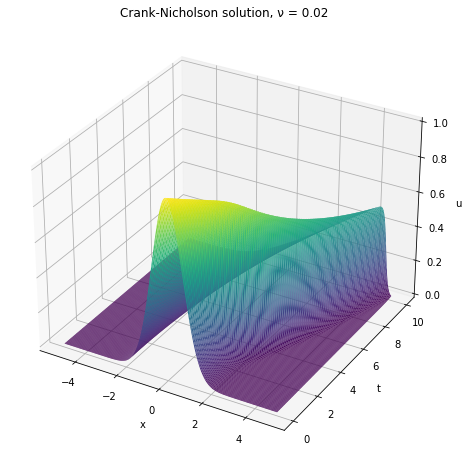

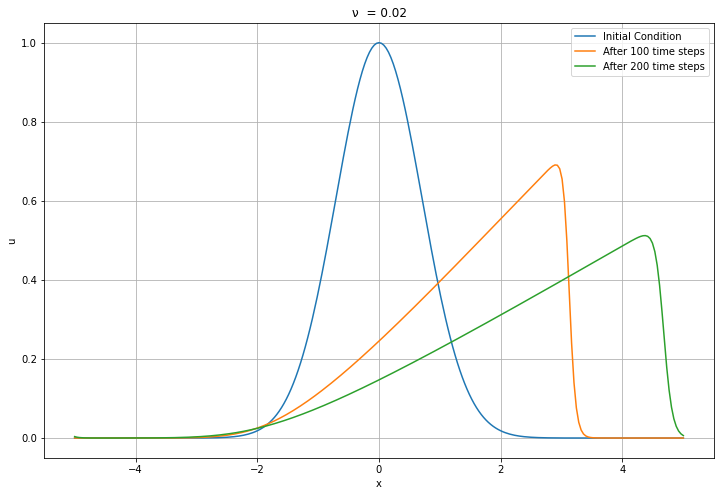

In [6]:
u = CK_Burger(N, nu, T, M, L, GaussianInitial)


ax = plt.axes(projection='3d')
ax.plot_surface(x_grid, t_grid, u, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Crank-Nicholson solution, ν = ' + str(nu));
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')
plt.savefig('Burger3d_002')
plt.figure()
plt.plot(x,GaussianInitial(x), label='Initial Condition')
plt.plot(x, u[:, int(M/2)], label='After ' + str(int(M/2))+ ' time steps')
plt.plot(x, u[:, M], label='After ' + str(M) + ' time steps')
plt.legend()
plt.title('ν  = ' + str(nu))
plt.xlabel('x')
plt.ylabel('u')
plt.grid(True)
plt.savefig('Burger2d_002')
plt.show()

In [7]:
Ut, R, rhs_des = build_linear_system(u, dt, dx, D=3, P=3, time_diff = 'FD', space_diff = 'FD')
['1'] + rhs_des[1:]

['1',
 'u',
 'u^2',
 'u^3',
 'u_{x}',
 'uu_{x}',
 'u^2u_{x}',
 'u^3u_{x}',
 'u_{xx}',
 'uu_{xx}',
 'u^2u_{xx}',
 'u^3u_{xx}',
 'u_{xxx}',
 'uu_{xxx}',
 'u^2u_{xxx}',
 'u^3u_{xxx}']

In [8]:
# Solve with STRidge
w = TrainSTRidge(R,Ut,10**-5,0.1)
print("PDE derived using STRidge")
print_pde(w, rhs_des)

PDE derived using STRidge
u_t = (-1.057625 +0.000000i)uu_{x}
    + (0.283156 +0.000000i)u^2u_{x}
    + (-0.258473 +0.000000i)u^3u_{x}
    + (0.019123 +0.000000i)u_{xx}
   


In [9]:
err = abs((D - w[8])*100)
print("Parameter error:", err, '%')

Parameter error: [298.08765323] %


In [10]:
err = abs(np.array([(-1 -  w[5])*100, (nu - w[8])*100/0.1]))
print("Error using PDE-FIND to identify Burger's equation:\n")
print("Mean parameter error:", mean(err), '%')
print("Standard deviation of parameter error:", std(err), '%')

Error using PDE-FIND to identify Burger's equation:

Mean parameter error: 3.319492531286819 %
Standard deviation of parameter error: 2.442960278899639 %


#### $\nu = 0.2$

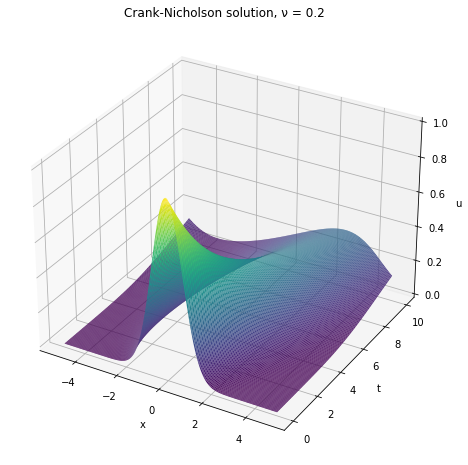

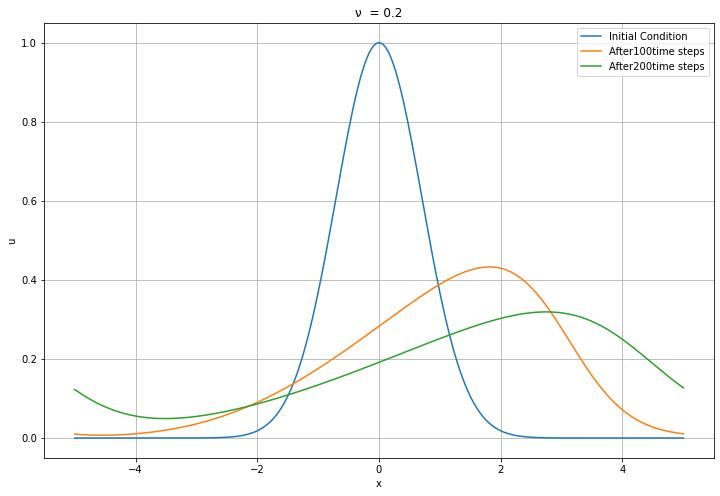

In [11]:
nu = 0.2
u = CK_Burger(N, nu, T, M, L, GaussianInitial)


ax = plt.axes(projection='3d')
ax.plot_surface(x_grid, t_grid, u, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Crank-Nicholson solution, ν = ' + str(nu));
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')
plt.savefig('Burger3d_02')

plt.figure()
plt.plot(x,GaussianInitial(x), label='Initial Condition')
plt.plot(x, u[:, int(M/2)], label='After' + str(int(M/2))+ 'time steps')
plt.plot(x, u[:, M], label='After' + str(M) + 'time steps')
plt.legend()
plt.title('ν  = ' + str(nu))
plt.xlabel('x')
plt.ylabel('u')
plt.grid(True)
plt.savefig('Burger2d_02')
plt.show()

In [12]:
Ut, R, rhs_des = build_linear_system(u, dt, dx, D=3, P=3, time_diff = 'FD', space_diff = 'FD')
['1'] + rhs_des[1:]

# Solve with STRidge
w = TrainSTRidge(R,Ut,10**-5,0.1)
print("PDE derived using STRidge")
print_pde(w, rhs_des)

PDE derived using STRidge
u_t = (-1.000166 +0.000000i)uu_{x}
    + (0.199643 +0.000000i)u_{xx}
   


In [13]:
err = abs((D - w[8])*100)
print("Parameter error:", err, '%')

Parameter error: [280.03566186] %


In [14]:
err = abs(np.array([(-1 -  w[5])*100, (nu - w[8])*100/0.1]))
print("Error using PDE-FIND to identify Burger's equation:\n")
print("Mean parameter error:", mean(err), '%')
print("Standard deviation of parameter error:", std(err), '%')

Error using PDE-FIND to identify Burger's equation:

Mean parameter error: 0.18660569628995982 %
Standard deviation of parameter error: 0.17001291921216466 %


#### $\nu = 2$

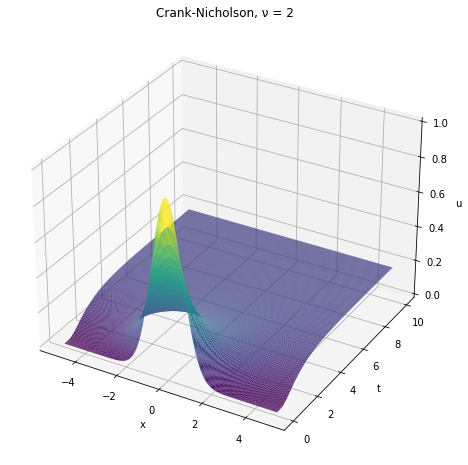

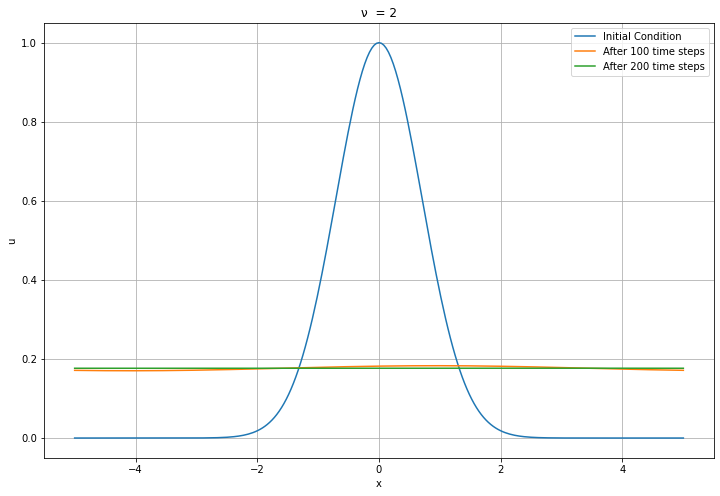

In [15]:
nu = 2
u = CK_Burger(N, nu, T, M, L, GaussianInitial)


ax = plt.axes(projection='3d')
ax.plot_surface(x_grid, t_grid, u, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Crank-Nicholson, ν = ' + str(nu));
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')
plt.savefig('Burger3d_2')

plt.figure()
plt.plot(x,GaussianInitial(x), label='Initial Condition')
plt.plot(x, u[:, int(M/2)], label='After ' + str(int(M/2))+ ' time steps')
plt.plot(x, u[:, M], label='After ' + str(M) + ' time steps')
plt.legend()
plt.title('ν  = ' + str(nu))
plt.xlabel('x')
plt.ylabel('u')
plt.grid(True)
plt.savefig('Burger2d_2')
plt.show()

In [20]:
Ut, R, rhs_des = build_linear_system(u, dt, dx, D=3, P=3, time_diff = 'FD', space_diff = 'FD')
['1'] + rhs_des[1:]

# Solve with STRidge
w = TrainSTRidge(R,Ut,10**-5,0.1)
print("PDE derived using STRidge")
print_pde(w, rhs_des)

PDE derived using STRidge
u_t = (-0.034076 +0.000000i)u
    + (0.260786 +0.000000i)u^2
    + (-0.391764 +0.000000i)u^3
    + (-1.126437 +0.000000i)uu_{x}
    + (1.396481 +0.000000i)u^2u_{x}
    + (-3.373824 +0.000000i)u^3u_{x}
    + (2.036277 +0.000000i)u_{xx}
    + (-0.740916 +0.000000i)uu_{xx}
    + (2.261798 +0.000000i)u^2u_{xx}
    + (-1.774167 +0.000000i)u^3u_{xx}
    + (-0.393433 +0.000000i)u^3u_{xxx}
   


In [21]:
err = abs(np.array([(-1 -  w[5])*100, (nu - w[8])*100/0.1]))
print("Error using PDE-FIND to identify Burger's equation:\n")
print("Mean parameter error:", mean(err), '%')
print("Standard deviation of parameter error:", std(err), '%')

Error using PDE-FIND to identify Burger's equation:

Mean parameter error: 29.460428933846316 %
Standard deviation of parameter error: 16.816765652873432 %


In [22]:
num_nu = 200
nus = np.zeros(num_nu)
ws = np.empty(((D+1)*(P+1), 1))
pdes = np.empty((0, num_nu), str)
errs_mean = []
errs_std =[]
errs_meanfloat = np.zeros(num_nu)

def get_pde(w, rhs_description, ut = 'u_t'):
    pde = ut + ' = '
    first = True
    w = w.ravel()
    for i in range(len(w)):
        if w[i] != 0:
            if not first:
                pde = pde + ' + '
            pde = pde + "(%05f %+05fi)" % (w[i].real, w[i].imag) + rhs_description[i]
            first = False
    return pde
    
for i in range(num_nu):
    nu = 0.01*(i+1)
    nus[i] = nu
    u = CK_Burger(N, nu, T, M, L, GaussianInitial)
    Ut, R, rhs_des = build_linear_system(u, dt, dx, D=3, P=3, time_diff = 'FD', space_diff = 'FD')
    ['1'] + rhs_des[1:]

    # Solve with STRidge
    w = TrainSTRidge(R,Ut,10**-5,0.1)
    w = w.transpose()
    ws = np.append(ws, w)
    pde = get_pde(w, rhs_des)
    pdes = np.append(pdes, pde)
    err = abs(np.array([(-1 -  w[0,5])*100, (nu - w[0,8])*100/0.1]))
    errs_meanfloat[i] = np.mean(err)
    me = str('%f' % np.mean(err)) + "%"
    st = str('%f' %np.std(err)) + "%"
    errs_mean = np.append(errs_mean, me)
    errs_mean
    errs_std = np.append(errs_std, st)
    if i == 10:
        print(err)
        print(str(mean(err)))
        print(me)
        print(errs_mean[i])
        print(type(errs_mean[i]))


[0.06808541 0.26292518]
0.1655052974675525
0.165505%
0.165505%
<class 'numpy.str_'>


In [23]:
from pandas import option_context


    
data1 = {
  "ν": nus,
  "PDE": pdes,
     "Mean parameter error": errs_mean,
    "Standard deviation of parameter error":errs_std
}
with option_context('display.max_colwidth', None):
    #load data into a DataFrame object:
    nu_pde = pd.DataFrame(data1)
    nu_pde.to_excel("Burger.xlsx",
             sheet_name='nu')  
    display(nu_pde)



,ν,PDE,Mean parameter error,Standard deviation of parameter error
0,0.01,u_t = (0.050140 +0.000000i)u + (-0.163713 +0.000000i)u^2 + (0.100025 +0.000000i)u^3 + (-1.301835 +0.000000i)uu_{x} + (0.936285 +0.000000i)u^2u_{x} + (-0.572205 +0.000000i)u^3u_{x} + (0.008165 +0.000000i)u_{xx} + (0.005066 +0.000000i)uu_{xx} + (-0.011850 +0.000000i)u^2u_{xx} + (0.006178 +0.000000i)u^3u_{xx} + (-0.000063 +0.000000i)u_{xxx} + (-0.000339 +0.000000i)uu_{xxx} + (0.001080 +0.000000i)u^2u_{xxx} + (-0.000774 +0.000000i)u^3u_{xxx},16.009310%,14.174193%
1,0.02,u_t = (-1.057625 +0.000000i)uu_{x} + (0.283156 +0.000000i)u^2u_{x} + (-0.258473 +0.000000i)u^3u_{x} + (0.019123 +0.000000i)u_{xx},3.319493%,2.442960%
2,0.03,u_t = (-0.995775 +0.000000i)uu_{x} + (0.029581 +0.000000i)u_{xx},0.420690%,0.001847%
3,0.04,u_t = (-0.997450 +0.000000i)uu_{x} + (0.039687 +0.000000i)u_{xx},0.283914%,0.028941%
4,0.05,u_t = (-0.998165 +0.000000i)uu_{x} + (0.049735 +0.000000i)u_{xx},0.224504%,0.040987%
...,...,...,...,...
195,1.96,u_t = (0.000259 +0.000000i) + (-0.037125 +0.000000i)u + (0.273716 +0.000000i)u^2 + (-0.415308 +0.000000i)u^3 + (0.054840 +0.000000i)u_{x} + (-1.854434 +0.000000i)uu_{x} + (4.091690 +0.000000i)u^2u_{x} + (-5.847110 +0.000000i)u^3u_{x} + (2.003957 +0.000000i)u_{xx} + (-0.705683 +0.000000i)uu_{xx} + (2.134452 +0.000000i)u^2u_{xx} + (-1.680116 +0.000000i)u^3u_{xx} + (-0.008479 +0.000000i)u_{xxx} + (0.057209 +0.000000i)uu_{xxx} + (0.128115 +0.000000i)u^2u_{xxx} + (-0.650093 +0.000000i)u^3u_{xxx},64.700098%,20.743303%
196,1.97,u_t = (0.000265 +0.000000i) + (-0.037818 +0.000000i)u + (0.279259 +0.000000i)u^2 + (-0.425601 +0.000000i)u^3 + (0.055280 +0.000000i)u_{x} + (-1.860819 +0.000000i)uu_{x} + (4.121555 +0.000000i)u^2u_{x} + (-5.891916 +0.000000i)u^3u_{x} + (2.014554 +0.000000i)u_{xx} + (-0.714624 +0.000000i)uu_{xx} + (2.156096 +0.000000i)u^2u_{xx} + (-1.697837 +0.000000i)u^3u_{xx} + (-0.008602 +0.000000i)u_{xxx} + (0.058000 +0.000000i)uu_{xxx} + (0.127442 +0.000000i)u^2u_{xxx} + (-0.653796 +0.000000i)u^3u_{xxx},65.317961%,20.763937%
197,1.98,u_t = (-0.033447 +0.000000i)u + (0.255408 +0.000000i)u^2 + (-0.381496 +0.000000i)u^3 + (-1.124759 +0.000000i)uu_{x} + (1.381919 +0.000000i)u^2u_{x} + (-3.343405 +0.000000i)u^3u_{x} + (2.025622 +0.000000i)u_{xx} + (-0.731475 +0.000000i)uu_{xx} + (2.239380 +0.000000i)u^2u_{xx} + (-1.756060 +0.000000i)u^3u_{xx} + (-0.390244 +0.000000i)u^3u_{xxx},29.049000%,16.573111%
198,1.99,u_t = (-0.034076 +0.000000i)u + (0.260786 +0.000000i)u^2 + (-0.391764 +0.000000i)u^3 + (-1.126437 +0.000000i)uu_{x} + (1.396481 +0.000000i)u^2u_{x} + (-3.373824 +0.000000i)u^3u_{x} + (2.036277 +0.000000i)u_{xx} + (-0.740916 +0.000000i)uu_{xx} + (2.261798 +0.000000i)u^2u_{xx} + (-1.774167 +0.000000i)u^3u_{xx} + (-0.393433 +0.000000i)u^3u_{xxx},29.460429%,16.816766%


,ν,Mean parameter error,Standard deviation of parameter error
0,0.01,16.009310%,14.174193%
1,0.02,3.319493%,2.442960%
2,0.03,0.420690%,0.001847%
3,0.04,0.283914%,0.028941%
4,0.05,0.224504%,0.040987%
...,...,...,...
195,1.96,64.700098%,20.743303%
196,1.97,65.317961%,20.763937%
197,1.98,29.049000%,16.573111%
198,1.99,29.460429%,16.816766%


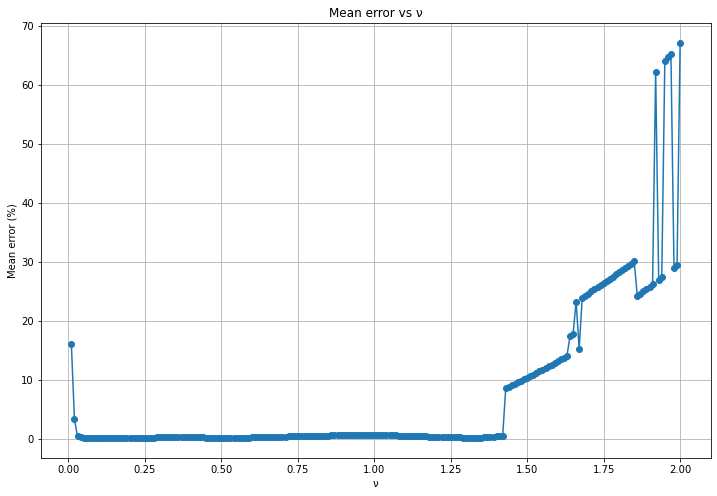

In [24]:
data2 = {
  "ν": nus,
  "Mean parameter error": errs_mean,
    "Standard deviation of parameter error":errs_std
}

#load data into a DataFrame object:
nu_err = pd.DataFrame(data2)
#nu_err.to_excel("Burger.xlsx",
#             sheet_name='err')  
display(nu_err)
plt.figure()
plt.plot(nus,errs_meanfloat, '-o')
plt.title('Mean error vs ν' )
plt.xlabel('ν')
plt.ylabel('Mean error (%)')
plt.grid(True)
plt.savefig('Error_nu.png')
plt.show()


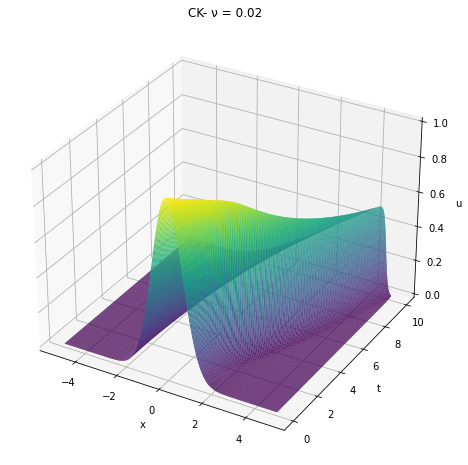

In [31]:
nu1 = 0.02
nu2 = 0.03
nu3 = 0.01

T = 10
M = 256 # number of time grids
N = 200 # number of spatial steps
L = 10
dx = L/N
dt = T/M

D = 3
P = 3

x = np.linspace(-L/2, L/2, N+1)
t = np.linspace(0, T, M+1)
t_grid, x_grid = np.meshgrid(t,x)

u_initial = sinInitial(x)
Ma = max(u_initial)

u1 = CK_Burger(N, nu1, T, M, L, GaussianInitial)


ax = plt.axes(projection='3d')
ax.plot_surface(x_grid, t_grid, u1, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('CK- ν = ' + str(nu1));
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')
plt.savefig('Burger3d_004.png')

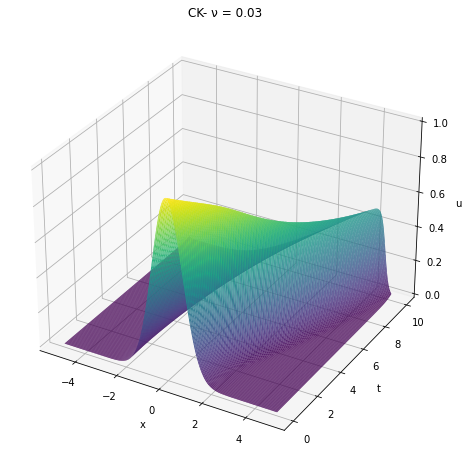

In [26]:
u2 = CK_Burger(N, nu2, T, M, L, GaussianInitial)
u3 = CK_Burger(N, nu3, T, M, L, GaussianInitial)
ax = plt.axes(projection='3d')
ax.plot_surface(x_grid, t_grid, u2, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('CK- ν = ' + str(nu2));
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')
plt.savefig('Burger3d_004.png')

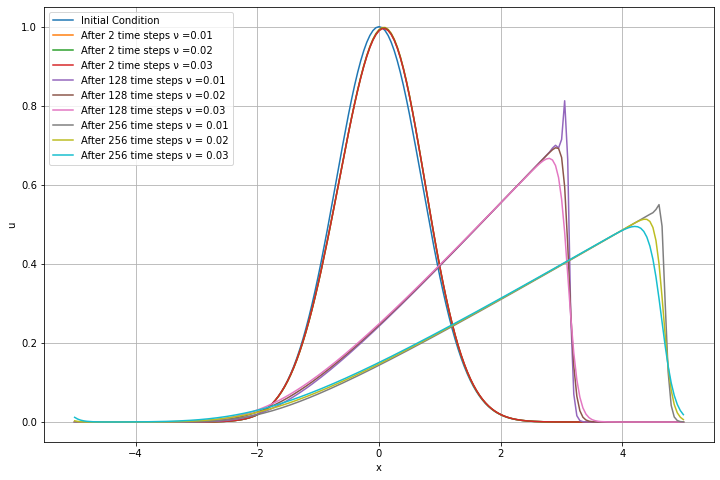

In [27]:
plt.figure()
plt.plot(x,GaussianInitial(x), label='Initial Condition')
plt.plot(x, u3[:, 2], label='After' + ' 2 '+ 'time steps ν =' + str(nu3))
plt.plot(x, u1[:, 2], label='After' + ' 2 '+ 'time steps ν =' + str(nu1))
plt.plot(x, u2[:, 2], label='After' + ' 2 '+ 'time steps ν =' + str(nu2))
plt.plot(x, u3[:, int(M/2)], label='After ' + str(int(M/2))+ ' time steps ν =' + str(nu3))
plt.plot(x, u1[:, int(M/2)], label='After ' + str(int(M/2))+ ' time steps ν =' + str(nu1))
plt.plot(x, u2[:, int(M/2)], label='After ' + str(int(M/2))+ ' time steps ν =' + str(nu2))
plt.plot(x, u3[:, M], label='After ' + str(M) + ' time steps ν = ' + str(nu3))
plt.plot(x, u1[:, M], label='After ' + str(M) + ' time steps ν = ' + str(nu1))
plt.plot(x, u2[:, M], label='After ' + str(M) + ' time steps ν = ' + str(nu2))


plt.legend()
plt.xlabel('x')
plt.ylabel('u')
plt.grid(True)
plt.savefig('Burger2d_002004.png')
plt.show()

As we can see from the table, PDE-FIND retrieves the correct terms for $\nu$ ranging from $0.04$ to $0.36$ and the parameter discovered is close to the exact parameters.
In this range, the graph is relatively smooth.  
The graph above shows that a shock wave is formed roughly between $\nu = 0.02$ and $\nu = 0.03$, which is the cut-off point of the failure of `PDE-FIND`.

### Adding Noise
#### Finite differences
We now choose $\nu = 0.20$ which falls within the range where `PDE-FIND` gives accurate result, and try adding noises to the function to see if PDE-FIND can still give the right result. Here we continue to use finite difference for derivative approximation.

In [32]:
nu = 0.20
u = CK_Burger(N, nu, T, M, L, GaussianInitial)


In [34]:
Ut, R, rhs_des = build_linear_system(u, dt, dx, D=3, P=3, time_diff = 'FD', space_diff = 'FD')
['1'] + rhs_des[1:]

# Solve with STRidge
w = TrainSTRidge(R,Ut,10**-5,0.1)
print("PDE derived using STRidge without noise")
print_pde(w, rhs_des)

PDE derived using STRidge without noise
u_t = (-1.000038 +0.000000i)uu_{x}
    + (0.199749 +0.000000i)u_{xx}
   


In [35]:
err = abs(np.array([(-1 -  w[5])*100, (nu - w[8])*100/0.1]))
print("Error using PDE-FIND to identify Burger's equation:\n")
print("Mean parameter error:", mean(err), '%')
print("Standard deviation of parameter error:", std(err), '%')

Error using PDE-FIND to identify Burger's equation:

Mean parameter error: 0.1271857752717903 %
Standard deviation of parameter error: 0.12343375506524146 %


**Introduce noises levels from $10^{-6}$ to $1$**

In [36]:
lams = np.array([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.1,1])
ws = np.empty(((D+1)*(P+1), 1))
pdes = np.empty((0, 7), str)
errs_mean = []
errs_std =[]
errs_meanfloat = []

for lam in lams:
    numpy.random.seed(0)
    un = u + lam*std(u)*np.random.randn(u.shape[0],u.shape[1])
    #u = CK_Burger(N, nu, T, M, L, GaussianInitial)
    Utn, Rn, rhs_des = build_linear_system(un, dt, dx, D=3, P=3, time_diff = 'FD', space_diff = 'FD')
    ['1'] + rhs_des[1:]

    # Solve with STRidge
    w = TrainSTRidge(Rn,Utn,10**-5,0.1)
    w = w.transpose()
    ws = np.append(ws, w)
    pde = get_pde(w, rhs_des)
    pdes = np.append(pdes, pde)
    err = abs(np.array([(-1 -  w[0,5])*100, (nu - w[0,8])*100/0.1]))
    errs_meanfloat = np.append(errs_meanfloat, np.mean(err))
    me = str('%f' % np.mean(err)) + "%"
    st = str('%f' %np.std(err)) + "%"
    errs_mean = np.append(errs_mean, me)
    errs_std = np.append(errs_std, st)


In [37]:
    
data1 = {
  "λ": lams,
  "PDE": pdes,
     "Mean parameter error": errs_mean,
   "Standard deviation of parameter error":errs_std
}
with option_context('display.max_colwidth', None):
    #load data into a DataFrame object:
    lam_pde = pd.DataFrame(data1)
    lam_pde.to_excel("Burger.xlsx", sheet_name='noise')  
    display(lam_pde)
    

,λ,PDE,Mean parameter error,Standard deviation of parameter error
0,0.000001,u_t = (-1.000039 +0.000000i)uu_{x} + (0.199750 +0.000000i)u_{xx},0.127182%,0.123314%
1,0.000010,u_t = (-1.000044 +0.000000i)uu_{x} + (0.199736 +0.000000i)u_{xx},0.133933%,0.129582%
2,0.000100,u_t = (-0.999500 +0.000000i)uu_{x} + (0.198224 +0.000000i)u_{xx},0.913115%,0.863088%
3,0.001000,u_t = (0.219123 +0.000000i)u + (-0.923587 +0.000000i)u^2 + (0.682835 +0.000000i)u^3 + (-0.173163 +0.000000i)u_{x} + (-0.284959 +0.000000i)uu_{x} + (-0.547503 +0.000000i)u^2u_{x} + (0.520867 +0.000000i)uu_{xx} + (-1.145580 +0.000000i)u^2u_{xx} + (0.852182 +0.000000i)u^3u_{xx},135.752030%,64.247970%
4,0.010000,u_t = (0.172602 +0.000000i)u + (-0.550072 +0.000000i)u^2 + (-0.141183 +0.000000i)u_{x} + (-0.759686 +0.000000i)uu_{x} + (0.938072 +0.000000i)u^2u_{x} + (-1.031920 +0.000000i)u^3u_{x},112.015678%,87.984322%
5,0.100000,u_t = (0.010143 +0.000000i) + (0.069416 +0.000000i)u + (-0.221787 +0.000000i)u^2 + (-0.287368 +0.000000i)u^3 + (0.008364 +0.000000i)u_{x} + (-0.405369 +0.000000i)uu_{x} + (-1.072230 +0.000000i)u^2u_{x} + (0.820787 +0.000000i)u^3u_{x} + (0.000158 +0.000000i)u_{xx} + (-0.005109 +0.000000i)uu_{xx} + (0.013394 +0.000000i)u^2u_{xx} + (-0.008248 +0.000000i)u^3u_{xx} + (-0.000004 +0.000000i)u_{xxx} + (0.000143 +0.000000i)uu_{xxx} + (-0.003028 +0.000000i)u^2u_{xxx} + (0.002418 +0.000000i)u^3u_{xxx},129.652353%,70.189296%
6,1.000000,u_t = (-0.170722 +0.000000i)u + (1.519424 +0.000000i)u^2 + (-2.104669 +0.000000i)u^3 + (0.269210 +0.000000i)u^2u_{x} + (-0.437237 +0.000000i)u^3u_{x} + (-0.000090 +0.000000i)u_{xx} + (0.000962 +0.000000i)uu_{xx} + (-0.003083 +0.000000i)u^2u_{xx} + (0.000783 +0.000000i)u^3u_{xx} + (-0.000008 +0.000000i)u_{xxx} + (0.000046 +0.000000i)uu_{xxx} + (0.000084 +0.000000i)u^2u_{xxx} + (-0.000215 +0.000000i)u^3u_{xxx},150.045132%,50.045132%
